# Quantifying SAM's performance on multi-class segmentation of crops in satellite imagery 

 * File Created: Sunday, 14th May 2023 9:10:24 pm
 * Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.13.1
True
8


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os

## Download SAM weights

In [4]:
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-20 16:57:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘cached_models/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.2MB/s    in 23s     

2023-06-20 16:57:43 (106 MB/s) - ‘cached_models/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-06-20 16:57:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [

## Testing Clusterings Consensus Metrics

In [4]:
from sklearn import metrics
def eval_clustering(labels_true, labels_pred):
    # ri = metrics.rand_score(labels_true, labels_pred)
    # true_labels_entropy, pred_labels_entropy = scipy.stats.entropy(labels_true), scipy.stats.entropy(labels_pred)
    # true_labels_info_gain, pred_labels_info_gain = scipy.stats.entropy(labels_true) / len(set(labels_true)), scipy.stats.entropy(labels_pred) / len(set(labels_pred))
    # kl_div = 1 - scipy.stats.entropy(labels_pred, qk=labels_true)
    ari = np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 3)
    mi = np.round(metrics.mutual_info_score(labels_true, labels_pred), 3)
    ami = np.round(metrics.adjusted_mutual_info_score(labels_true, labels_pred), 3)
    nmi = np.round(metrics.normalized_mutual_info_score(labels_true, labels_pred), 3)
    h = np.round(metrics.homogeneity_score(labels_true, labels_pred), 3)
    c = np.round(metrics.completeness_score(labels_true, labels_pred), 3)
    v = np.round(metrics.v_measure_score(labels_true, labels_pred), 3)
    fmi = np.round(metrics.fowlkes_mallows_score(labels_true, labels_pred), 3)

    return pd.Series([fmi,ari,mi,ami,nmi,h,c,v, 
                    #   true_labels_entropy, pred_labels_entropy, true_labels_info_gain, pred_labels_info_gain, kl_div
                    ], 
                     index=['FMI','ARI','MI','AMI','NMI','Homogeneity','Completeness','V-Measure',
                            # 'true_entropy', 'pred_entropy','true_info_gain', 'pred_info_gain', 'KL_divergence'
                        ])

## Test Cases:

### case: #1
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [10, 10, 11, 11, 12, 12]
# result = eval_clustering(labels_true, labels_pred)

### case: #2
# import random
# labels_true = random.sample(range(0,10), 6)
# labels_pred = random.sample(range(11,20), 6)
# print(labels_true, labels_pred)
# result = eval_clustering(labels_true, labels_pred)

### case: Mismatch in minority clusters 
labels_true = [10]*100+[1]*5
labels_pred = [3]*105
print()
print(eval_clustering(labels_true, labels_pred))

labels_true = [10]*1000+[1]*5
labels_pred = [3]*1005
print()
print(eval_clustering(labels_true, labels_pred))

labels_true = [10]*10000+[1]*5
labels_pred = [3]*10005
print()
print(eval_clustering(labels_true, labels_pred))

## case: equally distributed labels
labels_true = [10]*500 + [1]*500
labels_pred = [3]*800 + [2]*200
print()
print(eval_clustering(labels_true, labels_pred))

print("\n---> Perfect Clustering match <---")
labels_true = [10]*1000
labels_pred = [11]*1000
print()
print(eval_clustering(labels_true, labels_pred))


FMI             0.953
ARI             0.000
MI              0.000
AMI             0.000
NMI             0.000
Homogeneity     0.000
Completeness    1.000
V-Measure       0.000
dtype: float64

FMI             0.995
ARI             0.000
MI             -0.000
AMI            -0.000
NMI            -0.000
Homogeneity    -0.000
Completeness    1.000
V-Measure      -0.000
dtype: float64

FMI             1.0
ARI             0.0
MI              0.0
AMI             0.0
NMI             0.0
Homogeneity     0.0
Completeness    1.0
V-Measure       0.0
dtype: float64

FMI             0.651
ARI             0.159
MI              0.164
AMI             0.274
NMI             0.275
Homogeneity     0.236
Completeness    0.328
V-Measure       0.275
dtype: float64

---> Perfect Clustering match <---

FMI             1.0
ARI             1.0
MI              0.0
AMI             1.0
NMI             1.0
Homogeneity     1.0
Completeness    1.0
V-Measure       1.0
dtype: float64


## [DEADEND] Example: Segmenting AgNet Images 

### Utils for CDL plotting

In [ ]:
from colormap import getCDLRGB
def colormap_mask(temp):

    label_colors=[np.array(getCDLRGB(i)) for i in range(0,256)]
    label_colors=np.array(label_colors)
    
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,256):
        r[temp==l]=label_colors[l,0]
        g[temp==l]=label_colors[l,1]
        b[temp==l]=label_colors[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    return rgb

### Set up SAM mask generator with fixed PPS

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth" #"sam_vit_h_4b8939.pth"
model_type = "vit_l"

device = "cuda:7"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

img_w, img_h = 128,128
mask_generator = SamAutomaticMaskGenerator(model=sam,
                                            points_per_side=32,
                                            pred_iou_thresh=0.9,
                                            stability_score_thresh=0.92,
                                            crop_n_layers=1,
                                            crop_n_points_downscale_factor=2,
                                            min_mask_region_area=int(0.05*img_w*img_h),  # Requires open-cv to run post-processing
                                        )

In [ ]:
import glob, collections
# agnet_id =  '2015245_38_44' #'2015245_48_30' 
agnet_ids = [fp.split('/')[-1].split('_',1)[-1].split('_rgb')[0] for fp in  glob.glob("/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/*.tif")]
# print(agnet_ids)

from skimage import io as skio
from tqdm.notebook import tqdm
result_df = []
for agnet_id in tqdm(agnet_ids[:10]):
    # print("---> {} <---".format(agnet_id))
    
    image = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_{}_rgb.tif'.format(agnet_id))
    gt_mask = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/target/cdl_{}.tif'.format(agnet_id))
    # gt_mask_cmapped = colormap_mask(gt_mask)
    # print(collections.Counter(gt_mask.flatten()))

    # image = np.empty((128,128,7))

    # for i in range(7):
    #     image[:,:,i] = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/input/lc8_{}_{}.tif'.format(agnet_id,i+1))
    # image = image[0]

    # print(image.shape, gt_mask.shape)
    print(image.dtype)
    masks = mask_generator.generate(image)
    # print(len(masks))

    ## How many pixels got no mask?
    # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
    # print(pred_mask.shape)
    # print(collections.Counter(pred_mask.flatten()))

    ## Transform N boolean masks into one numerically encoded mask
    pred_mask = np.zeros((image.shape[0], image.shape[1]))
    for i, mask in enumerate(masks):
        pred_mask += np.where(mask['segmentation'] == True, i+1, 0)
    pred_mask = pred_mask.astype(int)
    # print(pred_mask.shape)
    # print(collections.Counter(pred_mask.flatten()))

    result = eval_clustering(gt_mask.flatten(), pred_mask.flatten())
    # result = metrics.fowlkes_mallows_score(labels_true, labels_pred)
    result_df.append(result)

result_df = pd.concat(result_df, axis=1).T

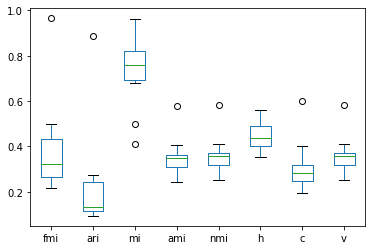

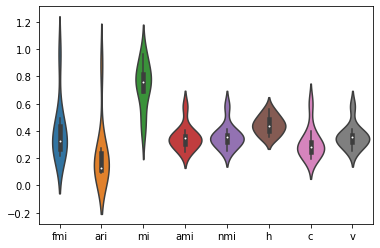

In [17]:
result_df.plot(kind='box')
plt.show()
sns.violinplot(data=result_df, inner='box')
plt.show() 

### [GRID SEARCH] Different PPS

  0%|          | 0/10 [00:00<?, ?it/s]

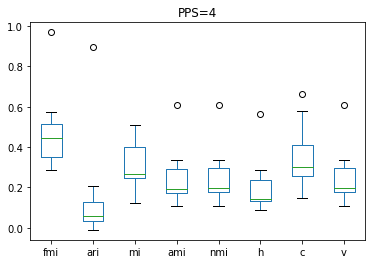

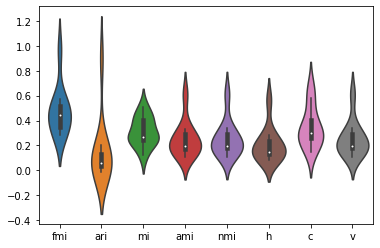

  0%|          | 0/10 [00:00<?, ?it/s]

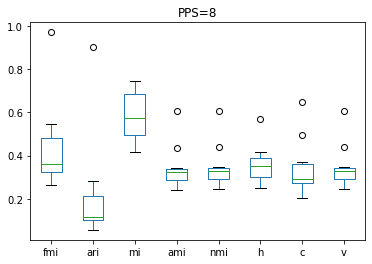

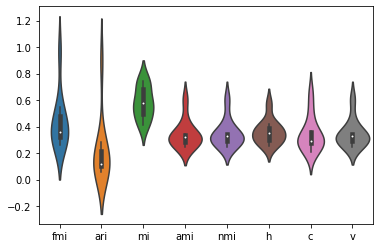

  0%|          | 0/10 [00:00<?, ?it/s]

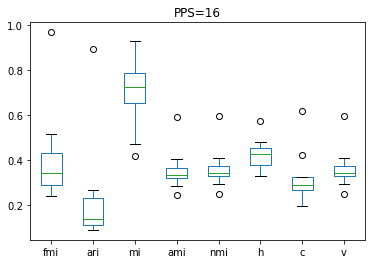

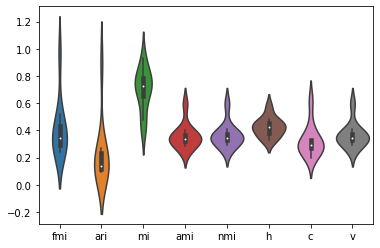

  0%|          | 0/10 [00:00<?, ?it/s]

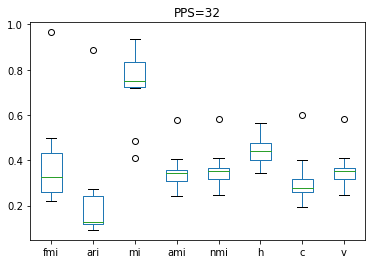

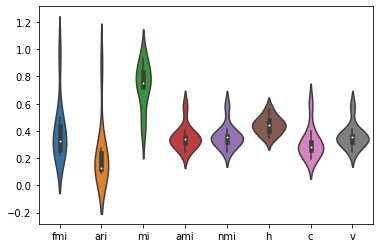

In [7]:
import glob, collections
from skimage import io as skio
from tqdm.notebook import tqdm

# agnet_id =  '2015245_38_44' #'2015245_48_30' 
agnet_ids = [fp.split('/')[-1].split('_',1)[-1].split('_rgb')[0] for fp in  glob.glob("/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/*.tif")]
# print(agnet_ids)

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth" #"sam_vit_h_4b8939.pth"
model_type = "vit_l"

device = "cuda:7"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

img_w, img_h = 128,128

for pps in [4,8,16,32]:
    mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                points_per_side=pps,
                                                pred_iou_thresh=0.9,
                                                stability_score_thresh=0.92,
                                                crop_n_layers=1,
                                                crop_n_points_downscale_factor=2,
                                                min_mask_region_area=int(0.05*img_w*img_h),  # Requires open-cv to run post-processing
                                            )

    result_df = []
    for agnet_id in tqdm(agnet_ids[:10]):
        # print("---> {} <---".format(agnet_id))
        
        image = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_{}_rgb.tif'.format(agnet_id))
        gt_mask = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/target/cdl_{}.tif'.format(agnet_id))
        # gt_mask_cmapped = colormap_mask(gt_mask)
        # print(collections.Counter(gt_mask.flatten()))

        # image = np.empty((128,128,7))
        # for i in range(7):
        #     image[:,:,i] = skio.imread('/data/rgura001/AI4CP/Ag-Net-Dataset/input/lc8_{}_{}.tif'.format(agnet_id,i+1))
        # image = image[0]

        # print(image.shape, gt_mask.shape)

        masks = mask_generator.generate(image)
        # print(len(masks))

        ## How many pixels got no mask?
        # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
        # print(pred_mask.shape)
        # print(collections.Counter(pred_mask.flatten()))

        ## Transform N boolean masks into one numerically encoded mask
        pred_mask = np.zeros((image.shape[0], image.shape[1]))
        for i, mask in enumerate(masks):
            pred_mask += np.where(mask['segmentation'] == True, i+1, 0)
        pred_mask = pred_mask.astype(int)
        # print(pred_mask.shape)
        # print(collections.Counter(pred_mask.flatten()))

        result = eval_clustering(gt_mask.flatten(), pred_mask.flatten())
        result_df.append(result)

    result_df = pd.concat(result_df, axis=1).T
    # result_df.plot(kind='box', title="PPS={}".format(pps))
    result_df.plot(kind='box', title="PPS={}".format(pps))
    plt.show()
    sns.violinplot(data=result_df, inner='box', title="PPS={}".format(pps))
    plt.show()

### [GRID SEARCH] Different AOIs and PPS

Plan: I'll tile the 128 x 128 samples and run sliding windows of different sizes.

In [25]:
import os, glob, collections
agnet_ids = [fp.split('/')[-1].split('_',1)[-1].split('_rgb')[0] for fp in  glob.glob("/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/*.tif")]
print(len(agnet_ids))
# agnet_ids = sorted(agnet_ids, key=lambda x: int(x.split('_')[1]))
# agnet_ids = sorted(agnet_ids, key=lambda x: int(x.split('_')[2]))
agnet_id_date = [int(id_.split('_')[0]) for id_ in agnet_ids]
agnet_id_x = [int(id_.split('_')[1]) for id_ in agnet_ids]
agnet_id_y = [int(id_.split('_')[2]) for id_ in agnet_ids]
print(len(set(agnet_id_date)), len(set(agnet_id_x)), len(set(agnet_id_y)))
print(agnet_id_date[:2], agnet_id_x[:2], agnet_id_y[:2])

# agnet_id_xy = [(int(id_.split('_')[1]), int(id_.split('_')[2])) for id_ in agnet_ids]
# print(len(agnet_id_xy))

# print(np.array(list(set(agnet_id_x))).astype(int).min(), np.array(list(set(agnet_id_x))).astype(int).max())
# print(np.array(list(set(agnet_id_y))).astype(int).min(), np.array(list(set(agnet_id_y))).astype(int).max())
# print(len(np.array(list(set(agnet_id_x))).astype(int)), len(np.array(list(set(agnet_id_y))).astype(int)))

1593
1 60 58
[2015245, 2015245] [29, 57] [37, 42]


In [49]:
from skimage import io as skio
from tqdm.notebook import tqdm

ids = list(zip(agnet_id_x, agnet_id_y))
ids.sort()
ids.sort(key=lambda x: x[0])
# print(ids)

images = []
for x, y in ids:
    id_ = "lc8_2015245_{}_{}_rgb".format(x,y)
    fp = "/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/{}.tif".format(id_)
    print(fp)

    # images.append(skio.imread(fp))
# print(len(images))

/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_1_13_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_1_14_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_2_13_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_2_15_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_2_17_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_2_18_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_2_19_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_3_14_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_3_16_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_3_19_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_3_20_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_3_22_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_4_13_rgb.tif
/data/rgura001/AI4CP/Ag-Net-Dataset/input_rgb/lc8_2015245_4_15_rgb.tif
/data/

I don't know how to tile the 128 x 128 images to create the full AOI for AgNet (on which I'll slide windows of bigger and bigger size to sample AOIs of different sizes) as the file ids suggest there are holes in the full AOI ???

I am moving on to CalCrop21.

## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### Creating RGB composite and saving them at different AOI sizes.

Note: This is implemented in make_aoi_samples.py. Run that script in background for larger datasets, do not run this in notebook.

In [4]:
import glob
DATA_DIR = "/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS"
filepaths = glob.glob(DATA_DIR+"/IMAGE_GRIDS/*.npy")
print(len(filepaths))
print(filepaths[:2])
tile_ids = [fp.split('/')[-1].rsplit('_',1)[0] for fp in filepaths]
print(tile_ids[:2])

367
['/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T10SFH_2018_2_1_IMAGE.npy', '/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T11SKV_2018_4_9_IMAGE.npy']
['T10SFH_2018_2_1', 'T11SKV_2018_4_9']


Compute NDVI cube for a tile, then use max NDVI timestep to create RGB render.

NDVI = (B8-B4) / (B8+B4)

In [5]:
with open("/home/rgura001/segment-anything/sam4crops/unusable_tiles.txt", 'r') as file:
    unusable_tiles = [line.rstrip() for line in file]
    
print(len(unusable_tiles))

20


In [ ]:
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor
import skimage
from PIL import Image
from utils import plot_sample

overlap = 0.5
SAVE_DIR = "/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_{}".format(overlap)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def make_aoi_samples(i, id_):
    image_multispec = np.load(DATA_DIR+"/IMAGE_GRIDS/{}_IMAGE.npy".format(id_))
    gt_mask = np.load(DATA_DIR+"/PREPROCESSED_CDL_GRIDS/{}_PREPROCESSED_CDL_LABEL.npy".format(id_))
    # print(image_multispec.shape, gt_mask.shape)

    B4, B8 = image_multispec[:,2,:,:], image_multispec[:,6,:,:]
    image_ndvi = np.divide((B8-B4), (B8+B4), out=np.zeros_like(B8), where=B4!=0)
    # print(image_ndvi.shape)
    max_ndvi_timestep = np.argmax(np.mean(image_ndvi, axis=(1,2)))
    # sorted_ndvi_timesteps = np.mean(image_ndvi, axis=(1,2)).argsort()[-24:][::-1]
    # print(max_ndvi_timestep)
    image = image_multispec[max_ndvi_timestep,[0,1,2],:,:].T * 255
    image = image.astype(int)
    # print(image.shape, image.min(), image.max())

    image = ndimage.rotate(np.fliplr(image), angle=90).astype('uint8')

    ## Filter out images that are all black like id_ == T10SEH_2018_1_8
    # if not Image.fromarray(image).getbbox(): ## img.getbbox() Returns False if there are no non-black pixels
        # print(id_)
        # return id_
    ## NOTE: Above is not sufficient to filter out all the other kinds of noisy samples. Resorting to manual filtering.

    ##-----------DEBUG--------------
    # plot_sample(img=image, mask=gt_mask, titlestr="Tile ID: {}".format(id_), 
    #             save=True, SAVE_PATH="/home/rgura001/segment-anything/sam4crops/results/eda/tile__{}.png".format(id_),
    #             show=False)
    ##------------------------------

    datapoint = np.concatenate((image, gt_mask[..., np.newaxis]), axis=-1) 
    max_shape = datapoint.shape[0]
    for split_ratio in [2, 4, 8, 16]:
        window_size = (max_shape//split_ratio, max_shape//split_ratio, datapoint.shape[-1])
        # views = np.lib.stride_tricks.sliding_window_view(datapoint, window_size, axis=(0,1))
        views = skimage.util.view_as_windows(datapoint, window_size, step=int(overlap*window_size[0])).squeeze()
        # print(views.shape)
        # np.save(SAVE_DIR+"/views/{}_maxNDVItimestep_rgb_size_{}.npy"
        #         .format(id_, samples.shape[2]), samples)
        samples = views.reshape(-1, views.shape[2], views.shape[3], views.shape[4])
        # print(samples.shape)
        
        aoi_save_dir = SAVE_DIR+"/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(samples.shape[1])
        if not os.path.exists(aoi_save_dir):
            os.makedirs(aoi_save_dir)
        
        for sample_idx in range(samples.shape[0]):
            sample = samples[sample_idx, ...] #[np.newaxis,...]
            # print(sample.shape)
            np.save(aoi_save_dir+"/{}_sample_{}_maxNDVItimestep_rgb_size_{}.npy"
                .format(id_, sample_idx, sample.shape[1]), sample)

        ##-----------DEBUG----------------------
        # plot_sample(img=sample[...,:3], mask=sample[...,-1], titlestr="Tile ID: {}, Sample #{}".format(id_, sample_idx), 
        #         save=True, SAVE_PATH="/home/rgura001/segment-anything/sam4crops/results/eda/tile__{}.png".format(id_),
        #         show=False)
        ##--------------------------------------
    
    # datapoint = datapoint[np.newaxis,...]
    aoi_save_dir = SAVE_DIR+"/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(datapoint.shape[1])
    if not os.path.exists(aoi_save_dir):
        os.makedirs(aoi_save_dir)

    np.save(aoi_save_dir+"/{}_sample_{}_maxNDVItimestep_rgb_size_{}.npy".format(id_, i, datapoint.shape[1]), datapoint)
    # print(datapoint.shape)

## Ususable tiles are either all black in RGB or are too contaminated with clouds 
# and errors introduced while removing them...
usable_tile_ids = [_id for _id in tile_ids if _id not in unusable_tiles]
results = Parallel(n_jobs=-1, verbose=1)(delayed(make_aoi_samples)(i, _id) for i, _id in tqdm(enumerate(usable_tile_ids)))
# print(results)
get_reusable_executor().shutdown(wait=True)

This is for mapping CalCrop21 crop-types with their CDL values so that I can visualize the CDL ground-truth appropriately.

In [6]:
class_names = ['Background','Corn','Cotton','Rice','Sunflower','Barley','Winter Wheat','Safflower','Dry Beans','Onions','Tomatoes','Cherries','Grapes','Citrus','Almonds','Walnuts','Pistachios','Garlic','Olives','Pomegranates','Alfalfa','Other Hay/Non Alfalfa','Barren','Fallow/Idle Cropland','Forest','Grassland/Pasture','Wetlands','Water','Developed']
labels_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
print(len(class_names), len(labels_list))

crop_legend = pd.read_csv("/data/rgura001/AI4CP/crop_legend_multilevel_encoded.csv")

cdl_values_list = []
for class_name in class_names:
    val = crop_legend[crop_legend['Crops_Level_1'] == class_name]['Crops_Level_1_enc'].to_list()[0]
    cdl_values_list.append(val)

print(cdl_values_list)
print(len(class_names), len(labels_list), len(cdl_values_list))

### Visualize Samples

In [5]:
aoi_sizes = [1098, 549, 274, 137, 68]
aoi_size = aoi_sizes[0]
SAMPLES_DIR = "/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = sorted(glob.glob(SAMPLES_DIR+"/*.npy"))
print(len(sample_filepaths), sample_filepaths[:2])

347 ['/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_1_9_sample_86_maxNDVItimestep_rgb_size_1098.npy', '/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_2_1_sample_29_maxNDVItimestep_rgb_size_1098.npy']


In [6]:
num_samples=10
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()
print(sample_idxes)

[102 270 106  71 188  20 102 121 214 330]


(1098, 1098, 4)
(1098, 1098, 3) (1098, 1098)


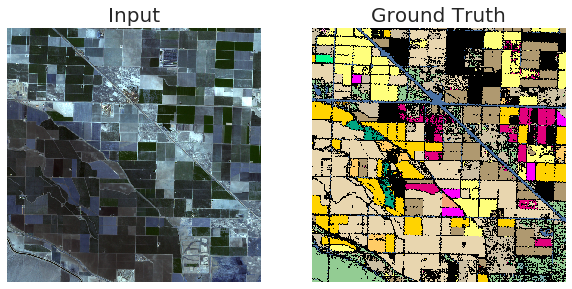

In [7]:
i = 9
sample = np.load(sample_filepaths[sample_idxes[i]])    
print(sample.shape)

image, mask = sample[...,:3].astype('uint8'), sample[...,-1] ## because SAM expects uint8 inputs
print(image.shape, mask.shape)

from utils import plot_sample
plot_sample(img=image, mask=mask)

### [TESTING] Grid Search: Varying PPS, MMRA for an AOI

In [4]:
RESULTS_DIR = "/home/rgura001/segment-anything/sam4crops/results/nbk"

/home/rgura001/segment-anything/cached_models/sam_vit_h_4b8939.pth
347


  0%|          | 0/2 [00:00<?, ?it/s]

1205 8


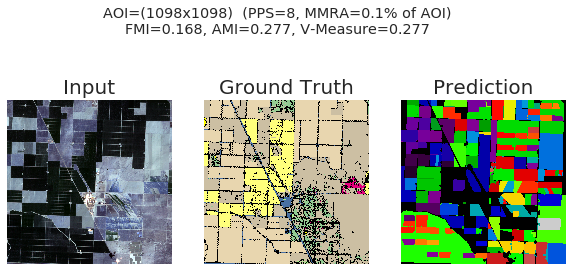

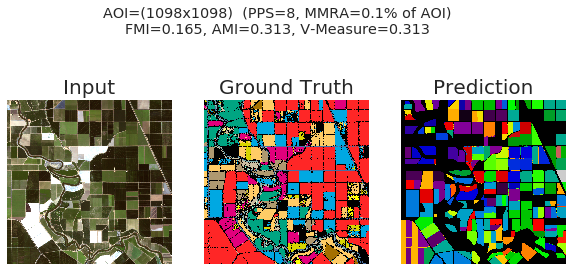

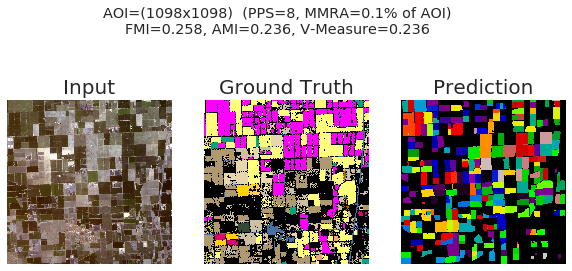

1205 16


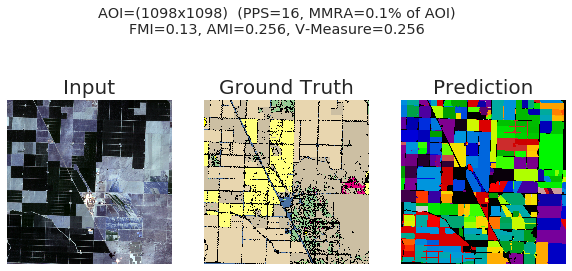

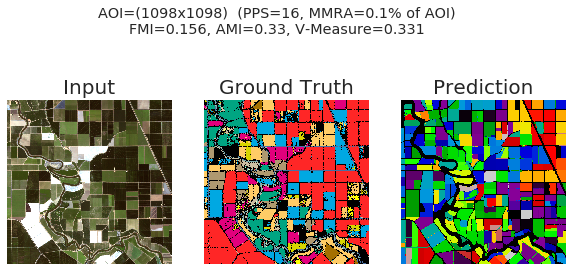

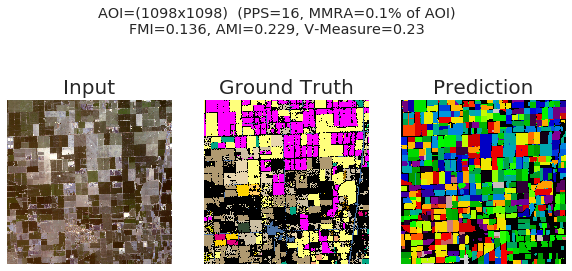

6028 8


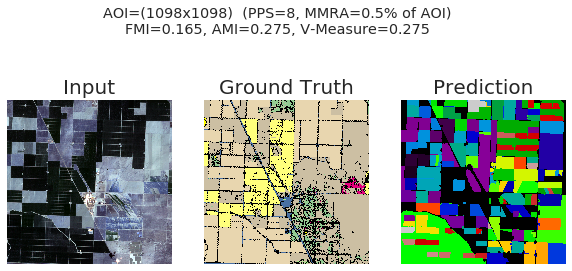

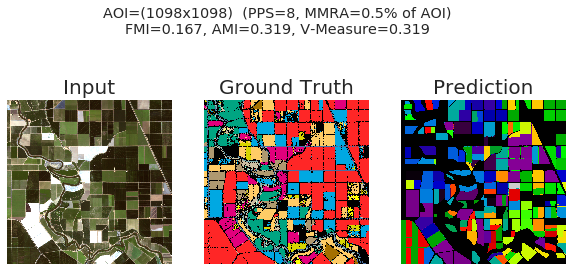

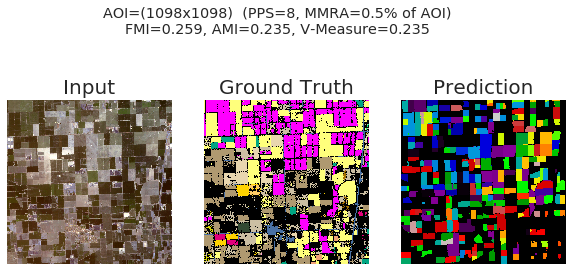

6028 16


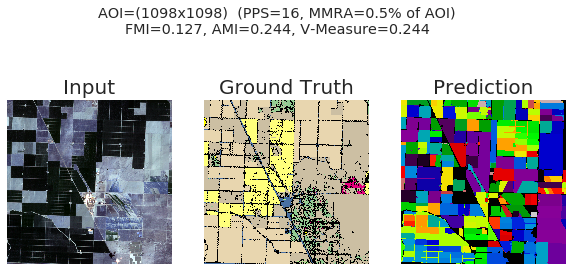

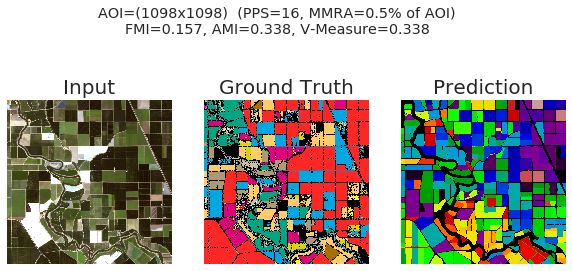

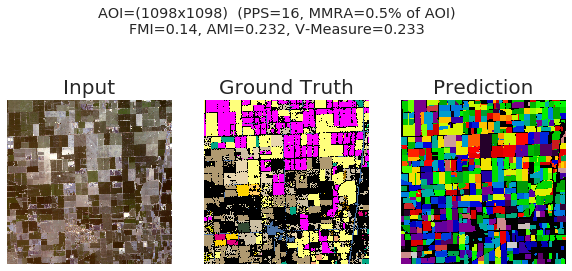

In [29]:
import glob, collections, random, json, os
# from skimage import io as skio
from sklearn import metrics
from PIL import Image
from tqdm.notebook import tqdm
from utils import plot_prediction

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "/home/rgura001/segment-anything/cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

aoi_size = 1098
img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs = [1e-3, 5*1e-3] #, 1e-2, 5*1e-2
# min_mask_region_areas = [int(frac*img_w*img_h) for frac in min_mask_region_fracs] 
# print(min_mask_region_areas)
pps_vals = [8,16]

num_samples=3
data_dir = "/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/"
AOI_SAMPLES_DIR = data_dir+"/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = glob.glob(AOI_SAMPLES_DIR+'/*.npy')
print(len(sample_filepaths))
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()

results = pd.DataFrame()
for min_mask_area_frac in tqdm(min_mask_region_fracs):
    min_mask_area = int(min_mask_area_frac*img_w*img_h)
    for pps in pps_vals:

        SAVE_DIR=RESULTS_DIR+'/aoi_size_{}/mmra_{}/pps_{}'.format(aoi_size, min_mask_area, pps)
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR+"/plots")

        titlestr = "AOI=({}x{})  (PPS={}, MMRA={}% of AOI)"\
                .format(img_w, img_h, pps, min_mask_area_frac*100)

        result_df = pd.DataFrame()
        result_df['sample_idx'] = sample_idxes
        result_df['PPS'] = [pps]*num_samples
        result_df['MMRA'] = [min_mask_area]*num_samples
        result_df['perc_MMRA'] = [min_mask_area_frac*100]*num_samples

        print(min_mask_area, pps)
        mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                    points_per_side=pps,
                                                    pred_iou_thresh=0.9,
                                                    stability_score_thresh=0.9,
                                                    crop_n_layers=1,
                                                    crop_n_points_downscale_factor=1,
                                                    min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                )

        scores = []
        for idx in sample_idxes:
            sample = np.load(sample_filepaths[idx])   
            image, gt_mask = sample[...,:3].astype('uint8'), sample[...,-1].astype('uint8')
            # print(image.shape, gt_mask.shape)
            
            masks = mask_generator.generate(image)
            # print(len(masks))

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            for i, mask in enumerate(masks):
                pred_mask += np.where(mask['segmentation'] == True, i+1, 0)
            pred_mask = pred_mask.astype('uint8')
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            sample_result_arr = np.concatenate([image, gt_mask[...,np.newaxis], pred_mask[...,np.newaxis]], axis=-1)
            # print(sample_result_arr.shape)
            np.save(SAVE_DIR+'/sample_{}'.format(idx), sample_result_arr)
            
            clust_score = eval_clustering(gt_mask.flatten(), pred_mask.flatten())
            scores.append(clust_score)

            plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
                            titlestr=titlestr+"\nFMI={}, AMI={}, V-Measure={}".format(clust_score['FMI'], clust_score['AMI'], clust_score['V-Measure']),
                            show=True, save=True, SAVE_PATH=SAVE_DIR+"/plots/sample_{}.png".format(idx)
                        )
        
        scores = pd.DataFrame(scores)
        col_names = result_df.columns.to_list()+scores.columns.to_list()
        result_df = pd.concat([result_df, scores], ignore_index=True, axis=1)
        result_df.columns = col_names
        results = pd.concat([results, result_df], ignore_index=True, axis=0)

results.to_csv(RESULTS_DIR+"/aoi_size_{}/results.csv".format(aoi_size), index=False)

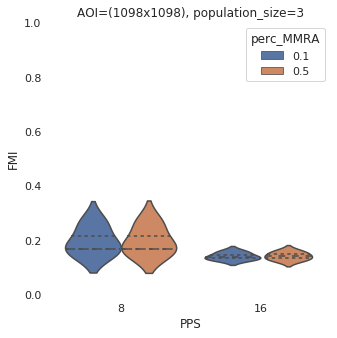

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.violinplot(data=results, x="PPS", y="FMI", hue="perc_MMRA", inner='quartile', ax=ax)
ax.set_ylim(0,1)
ax.set_title("AOI=({}x{}), population_size={}"
            .format(img_w, img_h, num_samples))
plt.show()

### Visualize grid search results

In [5]:
RESULTS_DIR = "/home/rgura001/segment-anything/sam4crops/results"

##### Sample Size = 10

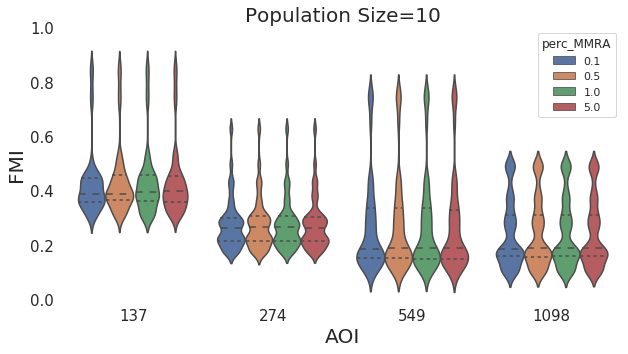

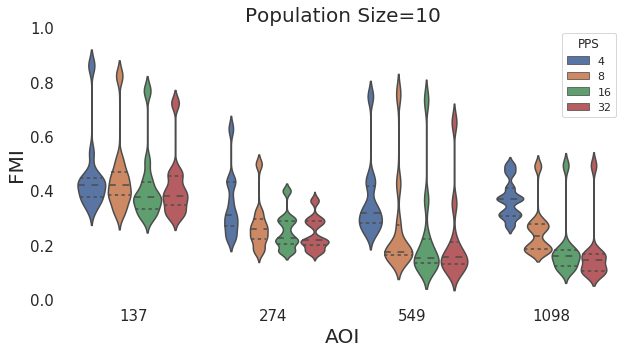

In [19]:
num_samples = 10
results = pd.read_csv(RESULTS_DIR+"/grid_search/num_samples_{}/results.csv".format(num_samples))

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="perc_MMRA", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax)
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="PPS", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax, )
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

##### Sample Size = 100

[BUG] Not filtered for all-black/blank and noisy images.

In [5]:
num_samples = 100
aoi_sizes = [1098, 549, 274, 137]
results = []
for aoi_size in aoi_sizes:
    results.append(pd.read_csv(RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/results.csv".format(num_samples, aoi_size)))
results = pd.concat(results)

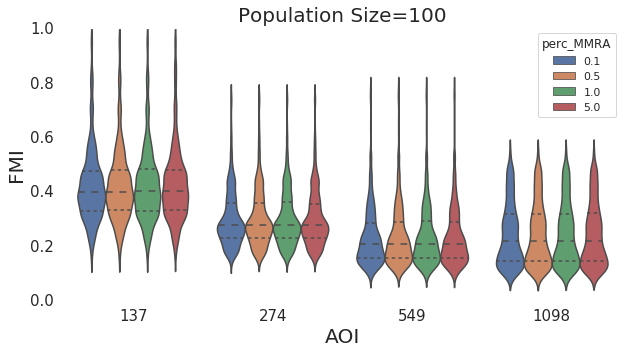

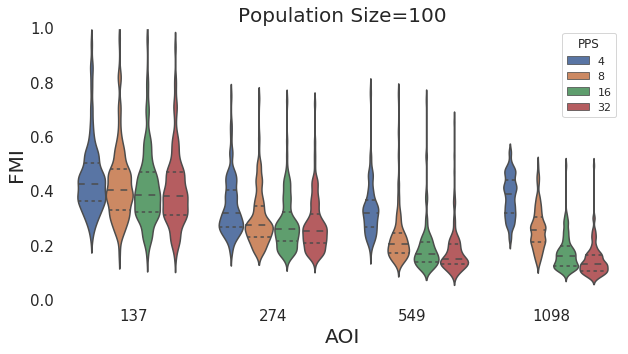

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="perc_MMRA", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax)
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="PPS", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax, )
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

In [7]:
results = results.sort_values(by=['FMI'], ascending=False)
results

sample_idx   AOI  PPS   MMRA  perc_MMRA       FMI
1599       61858   137    8     93        0.5  0.959560
1598       61858   137    8    187        1.0  0.959560
1597       61858   137    8     18        0.1  0.959560
1596       61858   137    8    938        5.0  0.959560
1595       61858   137   16     18        0.1  0.956619
...          ...   ...  ...    ...        ...       ...
4            303  1098   32   1205        0.1  0.081628
3            300  1098   32  12056        1.0  0.081429
2            303  1098   32  12056        1.0  0.081215
1            264  1098   32   1205        0.1  0.080163
0             64  1098   32   6028        0.5  0.079472

[6400 rows x 6 columns]

45


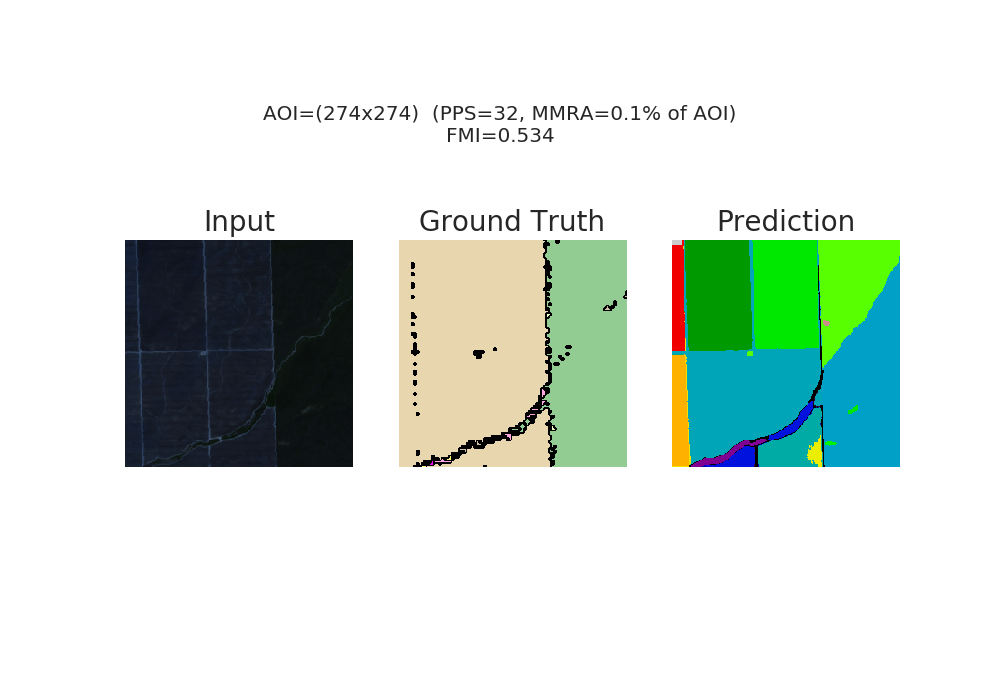

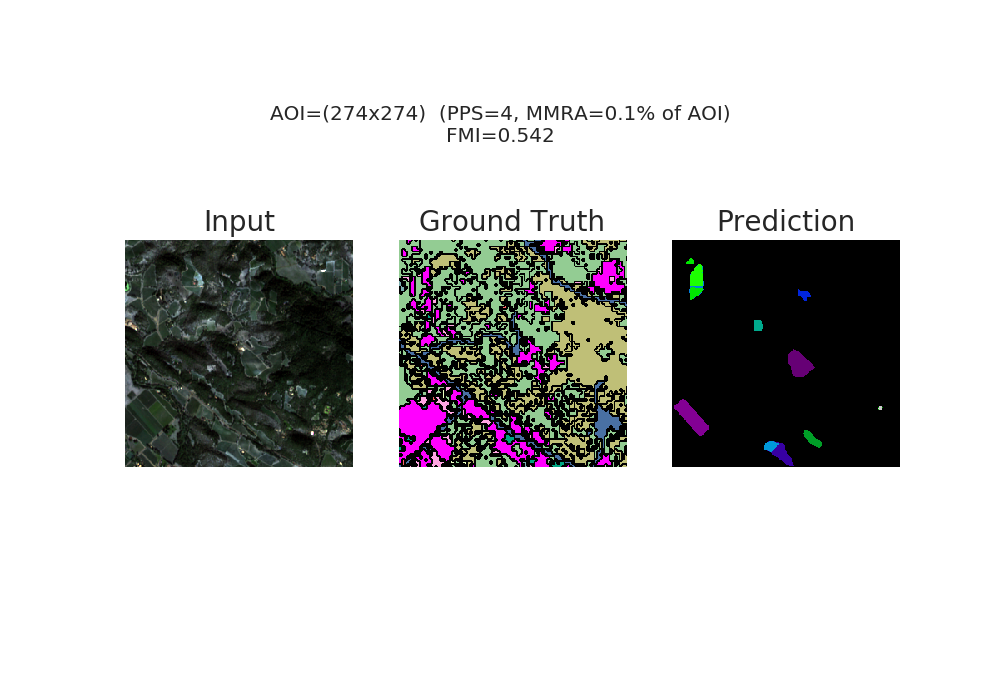

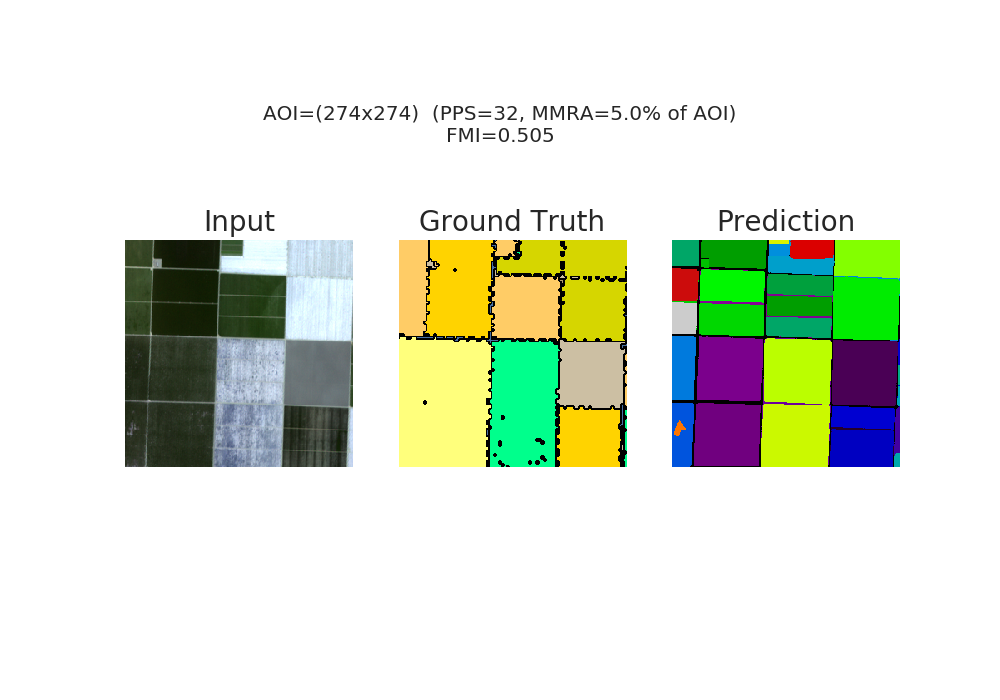

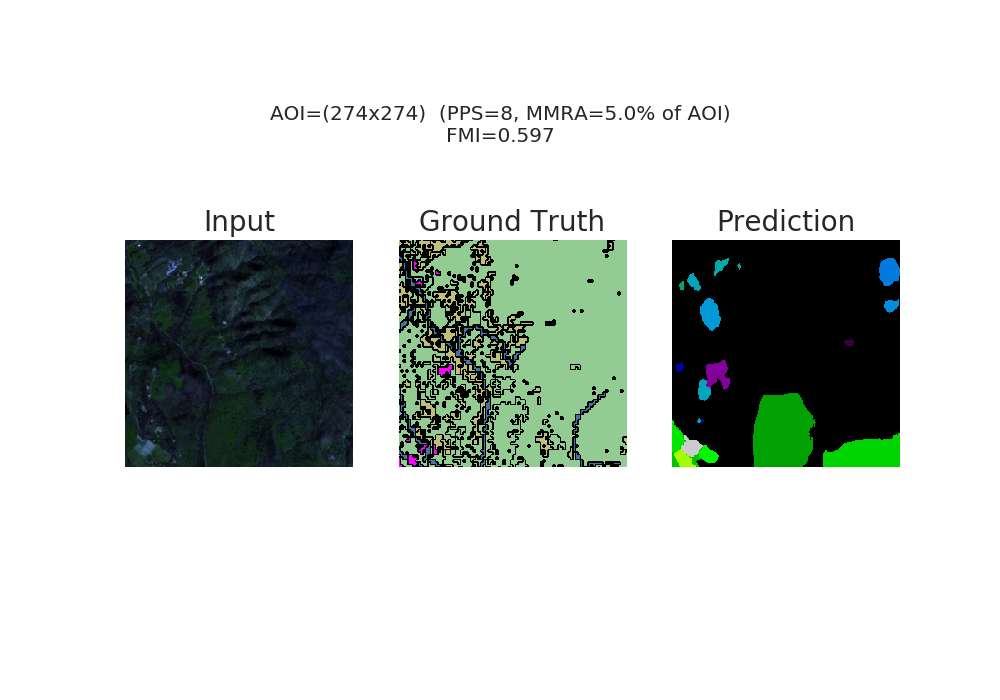

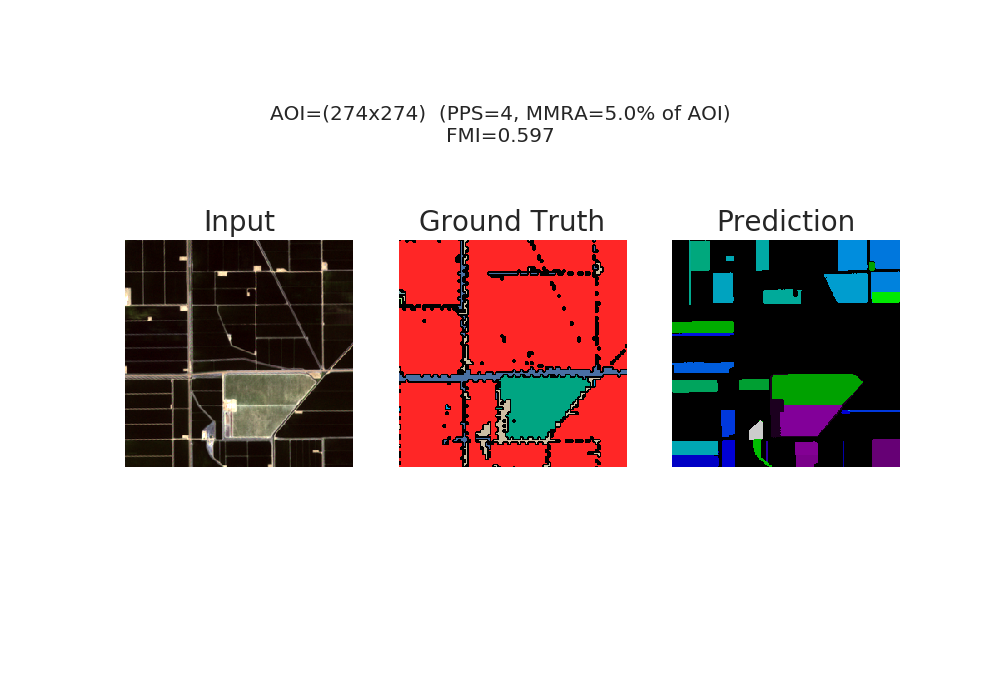

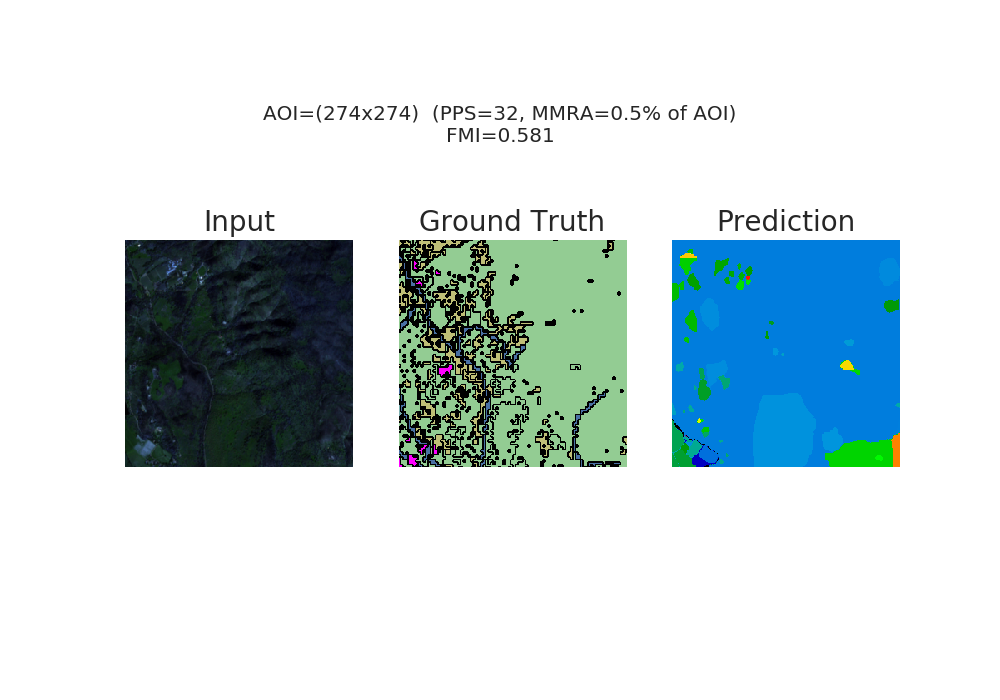

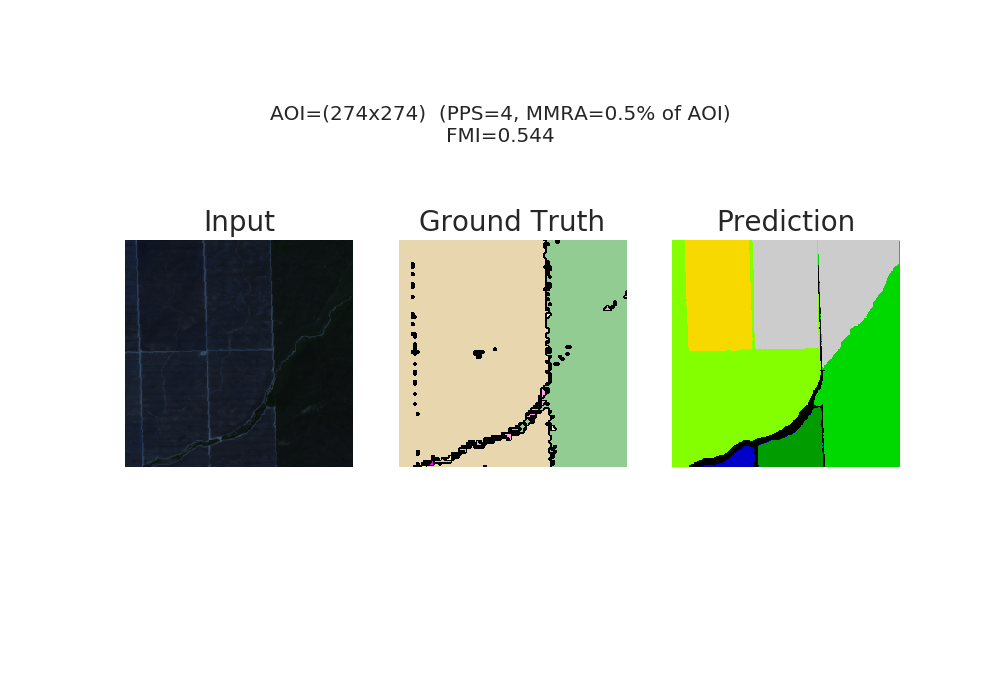

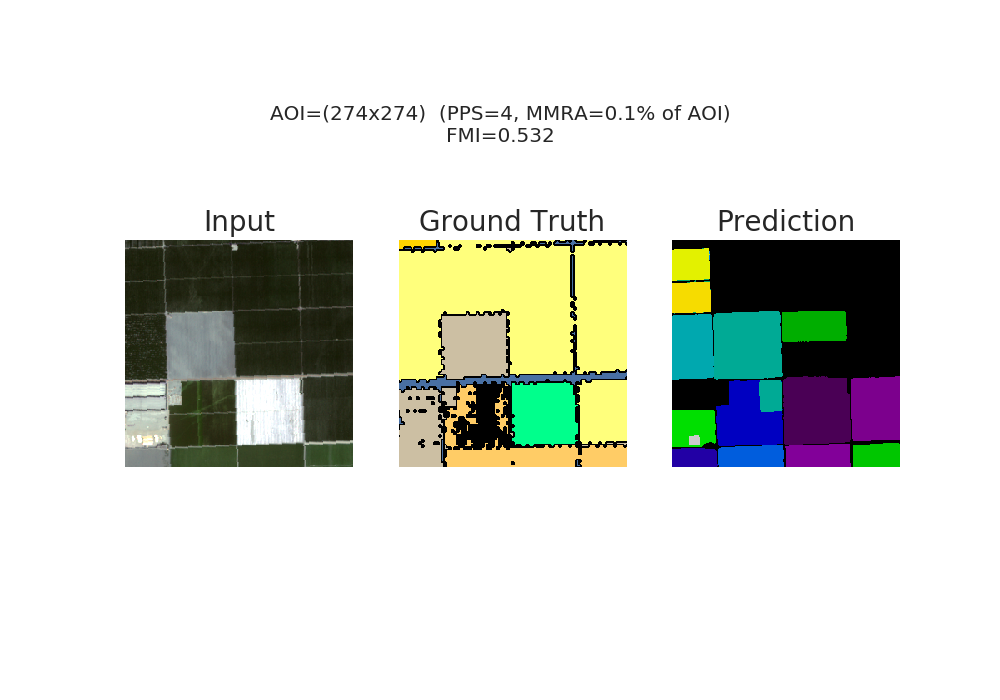

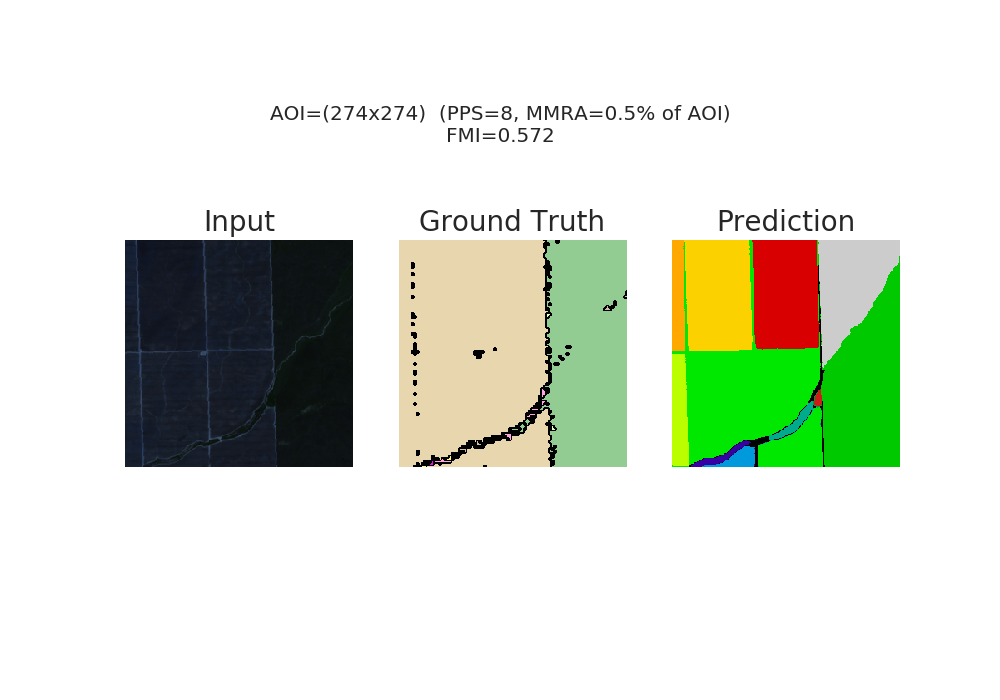

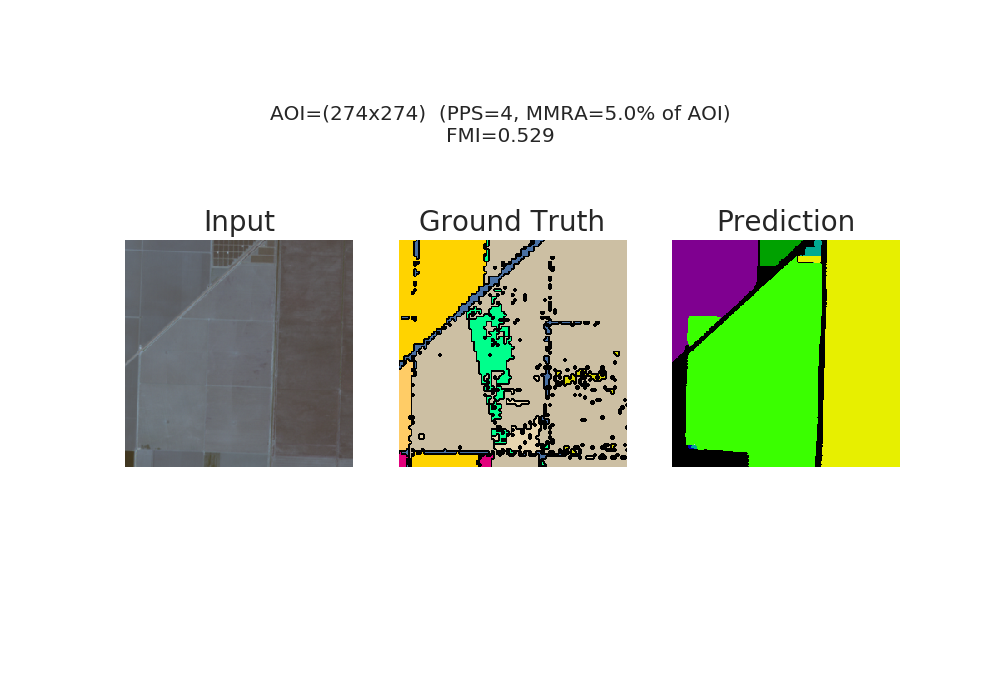

In [25]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.5, 0.6, inclusive=True)) & (results.AOI == 274)]
print(len(samples_to_display))
samples_to_display = samples_to_display.sample(10)

for index, row in samples_to_display.iterrows():
    # print(row['sample_idx'], row['AOI'], row['PPS'], row['MMRA'], row['FMI'])
    aoi_size, mmra, pps, sample_id = int(row['AOI']), row['perc_MMRA'].round(1), int(row['PPS']), int(row['sample_idx'])
    filepath = RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/mmra_{}/pps_{}/plots/sample_{}.png"\
                .format(num_samples, aoi_size, mmra, pps, sample_id)

    display(Image(filename=filepath))

##### Sample Size = 300

In [6]:
num_samples = 300
aoi_sizes = [1098, 549, 274, 137]
results = []
for aoi_size in aoi_sizes:
    results.append(pd.read_csv(RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/results.csv".format(num_samples, aoi_size)))
results = pd.concat(results)

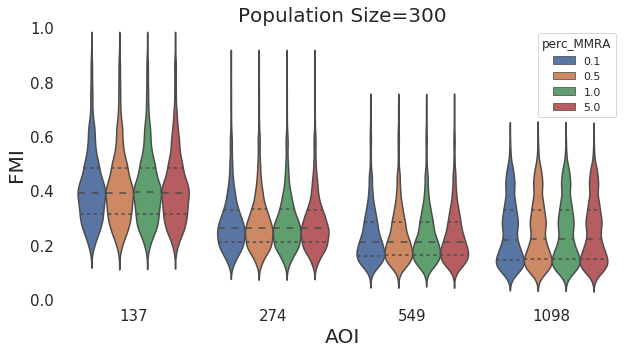

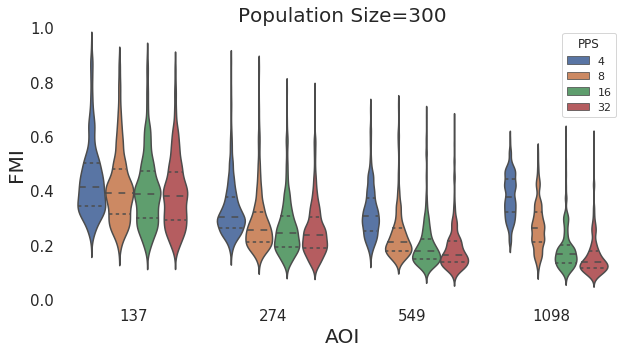

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="perc_MMRA", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax)
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.tick_params(axis='both', which='major', labelsize=15)
plot = sns.violinplot(data=results, x="AOI", y="FMI", hue="PPS", 
                bw = 0.2,  cut=2,
                inner='quartile', ax=ax, )
plot.set_ylabel(plot.get_ylabel(), size=20)
plot.set_xlabel(plot.get_xlabel(), size=20)
ax.set_ylim(0,1)
ax.set_title("Population Size={}".format(num_samples), fontsize=20)
plt.show()

In [9]:
results = results.sort_values(by=['FMI'], ascending=False)
results

sample_idx   AOI  PPS   MMRA  perc_MMRA    FMI    ARI     MI    AMI  \
1277        2568   137    4     93        0.5  0.930  0.434  0.093  0.297   
77          2568   137    4     18        0.1  0.930  0.434  0.093  0.297   
3677        2568   137    4    938        5.0  0.930  0.434  0.092  0.297   
2477        2568   137    4    187        1.0  0.930  0.434  0.093  0.298   
677         2568   137   16     18        0.1  0.890  0.317  0.097  0.216   
...          ...   ...  ...    ...        ...    ...    ...    ...    ...   
1011          61  1098   32   1205        0.1  0.080 -0.006  0.506  0.164   
1053          61  1098   32   1205        0.1  0.080 -0.006  0.506  0.164   
3568          74  1098   32  12056        1.0  0.078  0.004  0.604  0.183   
2368          74  1098   32   6028        0.5  0.078  0.004  0.615  0.186   
4768          74  1098   32  60280        5.0  0.075  0.002  0.591  0.179   

        NMI  Homogeneity  Completeness  V-Measure  
1277  0.298        0.378         0.246      0.298  
77    0.298        0.378         0.246      0.298  
3677  0.298        0.377         0.246      0.298  
2477  0.298        0.378         0.247      0.298  
677   0.218        0.396         0.150      0.218  
...     ...          ...           ...        ...  
1011  0.165        0.428         0.102      0.165  
1053  0.165        0.428         0.102      0.165  
3568  0.183        0.402         0.119      0.183  
2368  0.186        0.409         0.121      0.186  
4768  0.179        0.393         0.116      0.179  

[19200 rows x 13 columns]

Looks like, as expected, the high FMI samples have smaller AOI.

Let's take a look at samples in the tails and figure out what's different between samples in top and bottom tails.

67


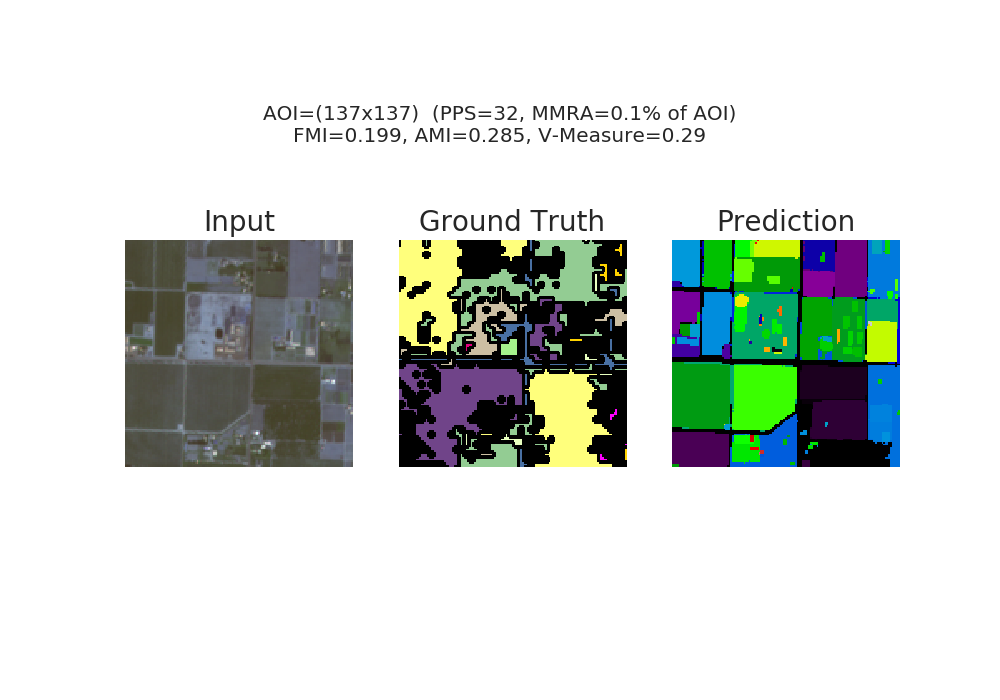

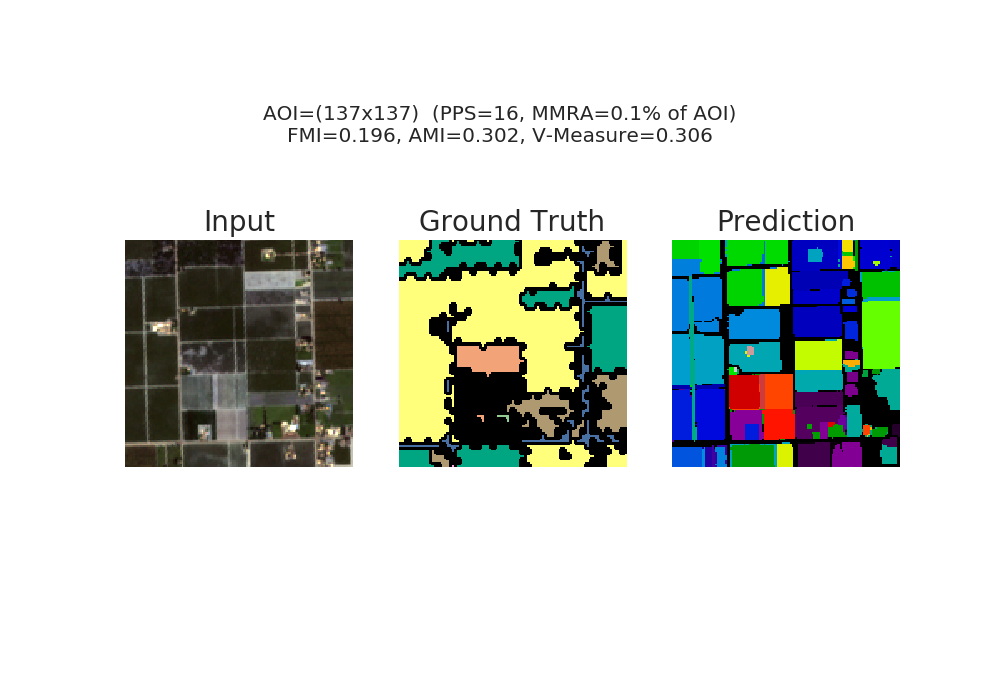

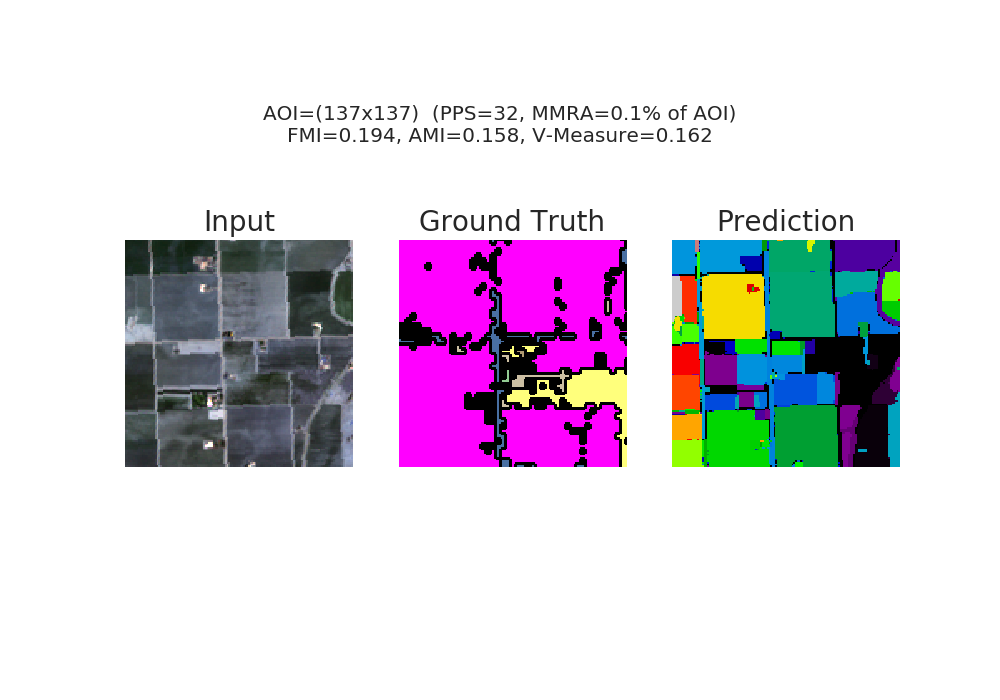

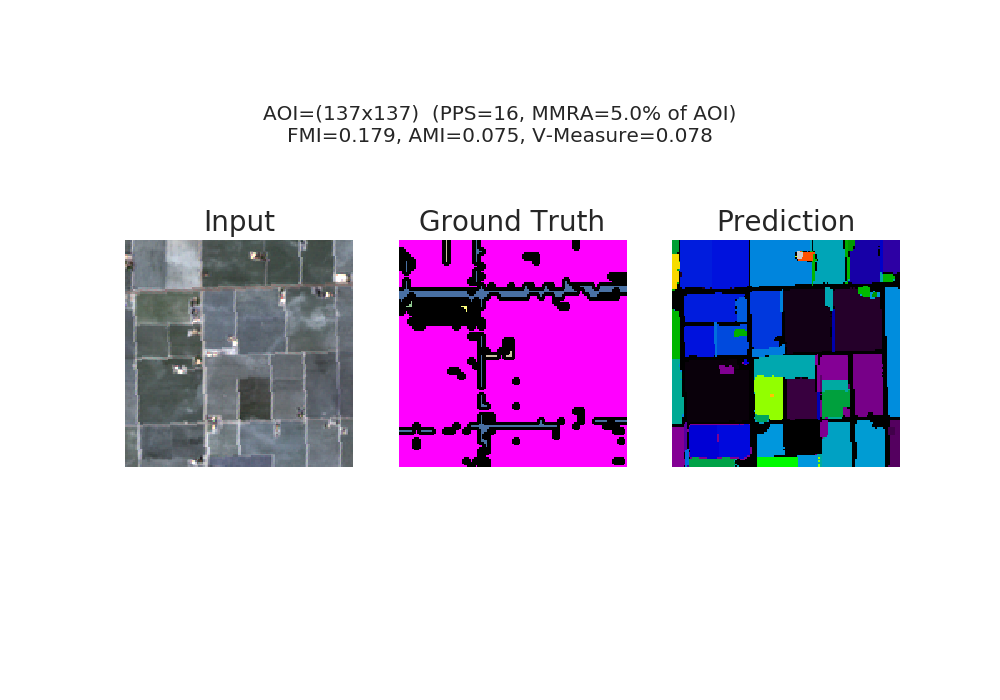

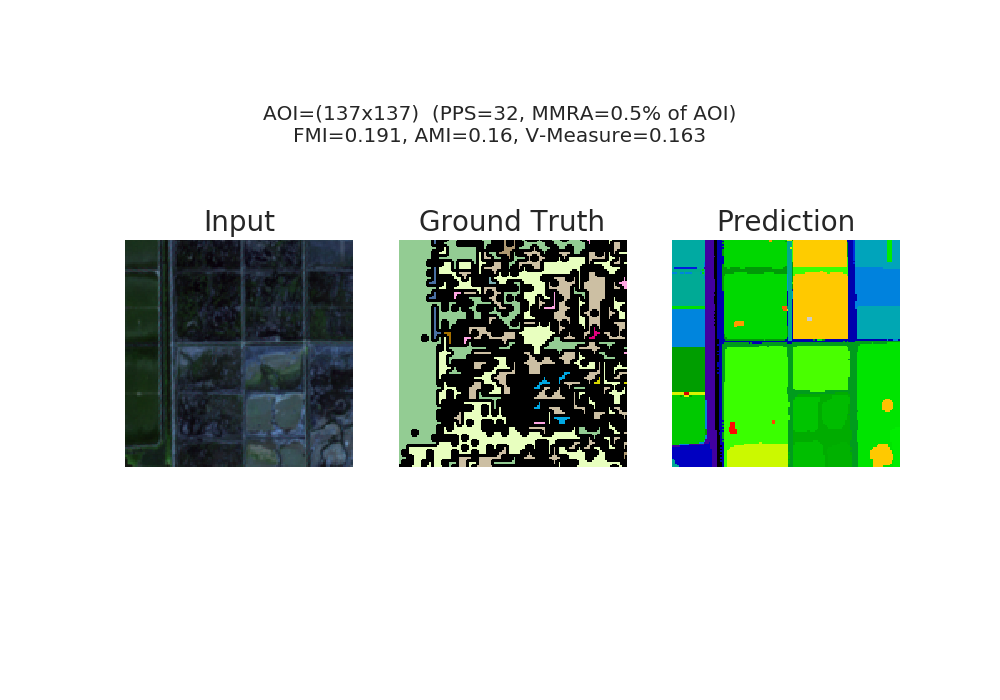

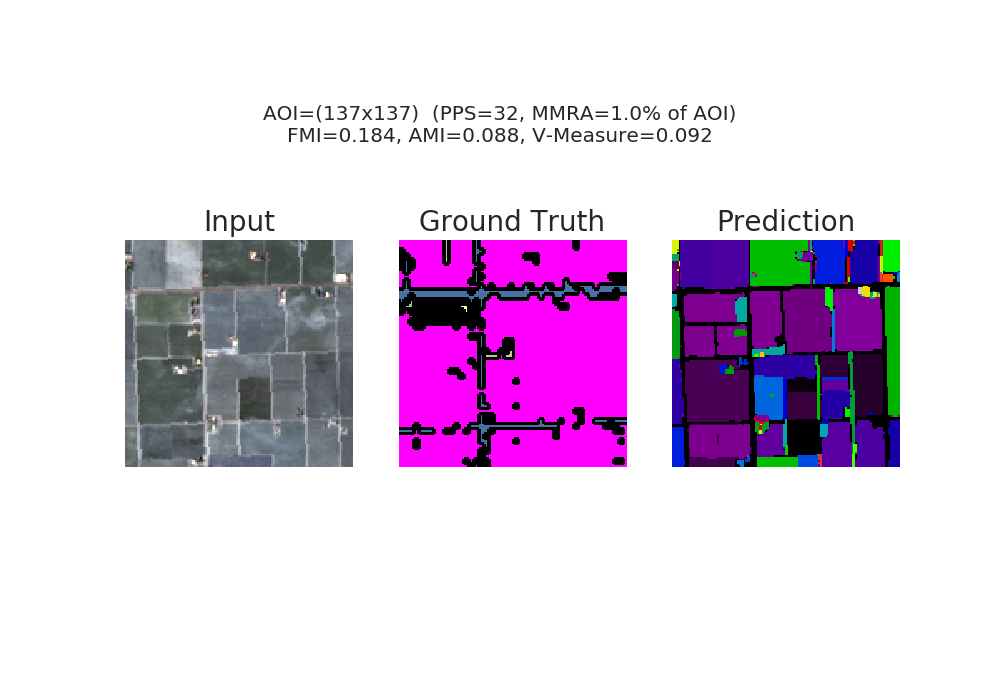

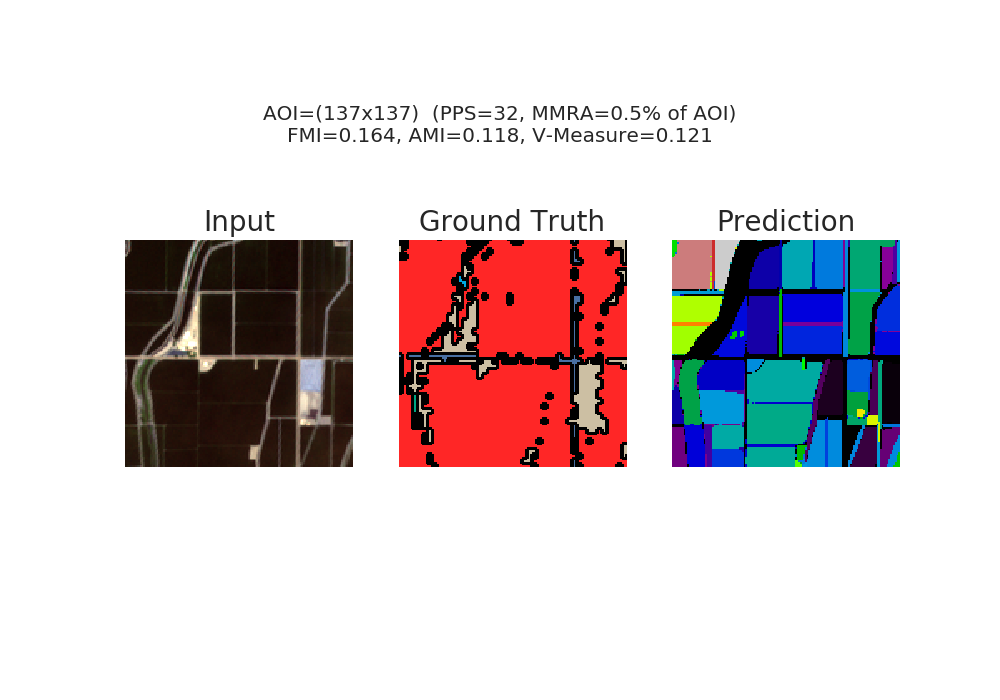

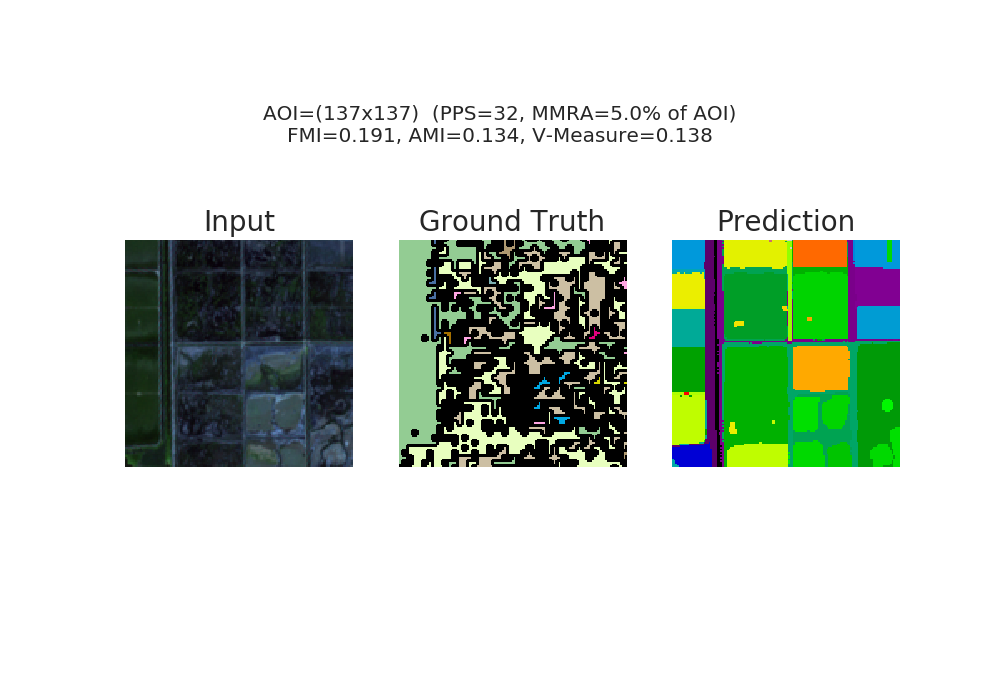

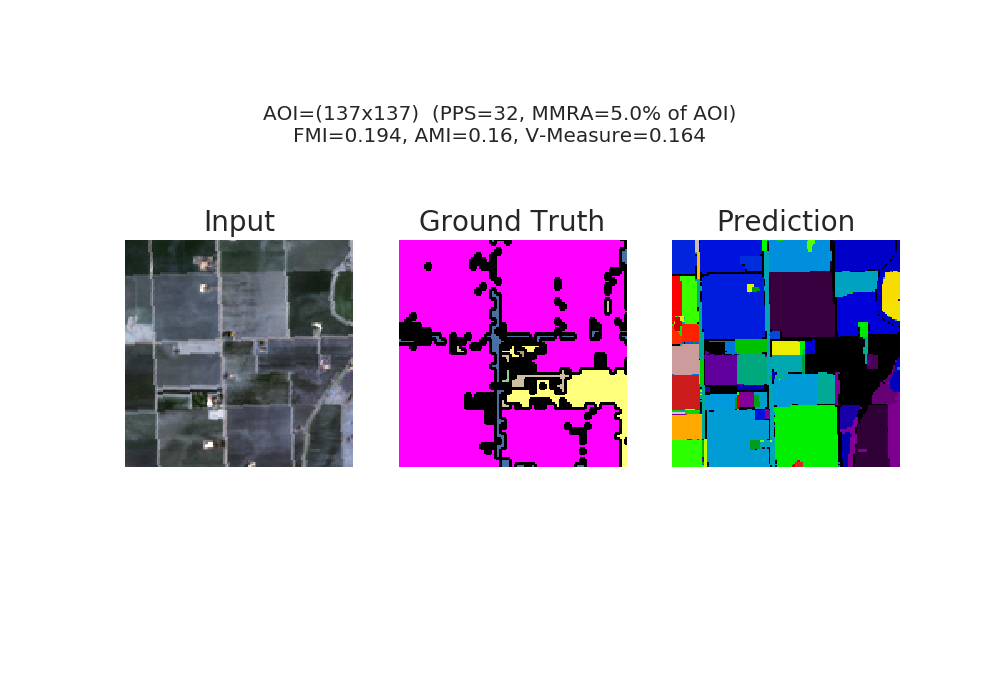

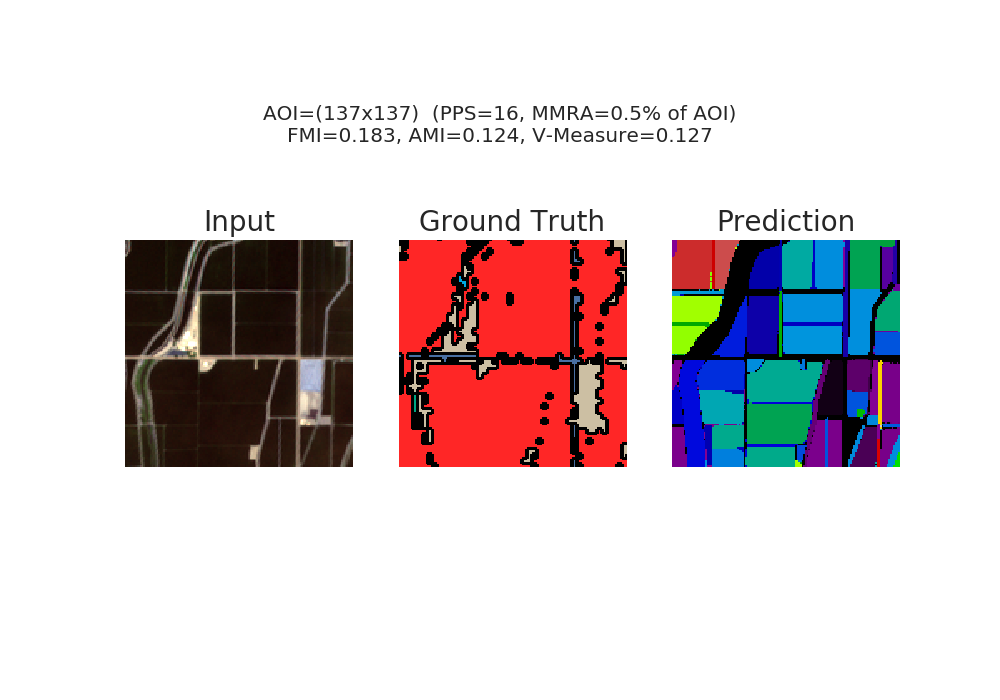

In [14]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.0, 0.2, inclusive=True)) & (results.AOI == 137)]
print(len(samples_to_display))

n=10
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(10)

for index, row in samples_to_display.iterrows():
    # print(row['sample_idx'], row['AOI'], row['PPS'], row['MMRA'], row['FMI'])
    aoi_size, mmra, pps, sample_id = int(row['AOI']), row['perc_MMRA'].round(1), int(row['PPS']), int(row['sample_idx'])
    filepath = RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/mmra_{}/pps_{}/plots/sample_{}.png"\
                .format(num_samples, aoi_size, mmra, pps, sample_id)

    display(Image(filename=filepath))

### [POSSIBLE DEADEND] Scoring samples based on label contiguity

In [7]:
from scipy import ndimage
def is_contiguous(img_array, label):
    labeled_array, num_labels = ndimage.label(img_array == label)
    if num_labels == 1:
        flag = True
        print(label, '+', set(labeled_array.flatten()))
    else:
        sizes = ndimage.sum(img_array == label, labeled_array, range(num_labels + 1))
        largest_label = np.argmax(sizes) # np.argmax(sizes[1:]) + 1
        print(label, '-', set(labeled_array.flatten()), largest_label, sizes)
        flag = np.all(labeled_array == largest_label)
        print(np.where(labeled_array == largest_label, True, False).sum())
        print()
    return flag

def avg_contiguity_score(img_array):
    frac_pix_by_label = []
    labels = list(set(img_array.flatten()))
    for label in labels:
        if is_contiguous(img_array, label):
            frac = (img_array == label).sum() / img_array.size
            frac_pix_by_label.append((img_array == label).sum() / img_array.size)
    if frac_pix_by_label:
        score = np.mean(frac_pix_by_label).round(3) ## From Het
        # score = np.sum(frac_pix_by_label).round(3) ## From Rutuja
        return score
    else:
        return 0.0

0 - {0, 1, 2} 1 [   0. 2500. 2500.]
2500

2 + {0, 1}
5 + {0, 1}
0 - {0, 1, 2} 1 [   0. 2500. 2500.]
2500

2 + {0, 1}
5 + {0, 1}


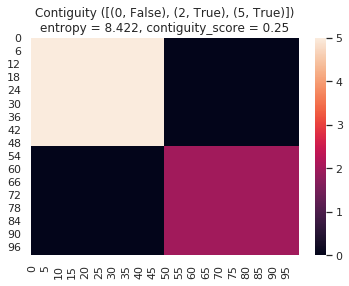

0 - {0, 1, 2} 1 [   0. 2500. 2500.]
2500

2 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} 11 [0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 2.49e+03]
2490

5 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} 1 [0.00e+00 2.49e+03 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 1.00e+00]
2490

0 - {0, 1, 2} 1 [   0. 2500. 2500.]
2500

2 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} 11 [0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 2.49e+03]
2490

5 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} 1 [0.00e+00 2.49e+03 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 1.00e+00 1.00e+00 1.00e+00]
2490



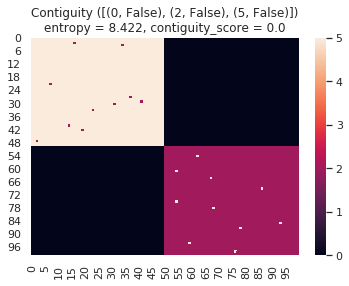

1 + {0, 1}
5 + {0, 1}
1 + {0, 1}
5 + {0, 1}


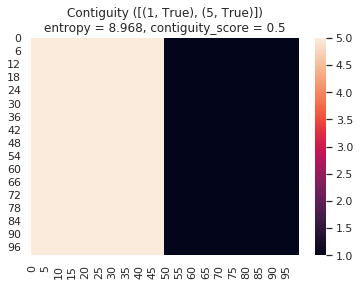

In [8]:
import numpy as np
import seaborn as sns

n, k = 100, 0.5
img = np.block([
    [np.ones((int(n*k),int(n*k)))*5, np.zeros((int(n*k),int(n*(1-k))))],
    [np.zeros((int(n*(1-k)),int(n*k))), np.ones((int(n*(1-k)), int(n*(1-k))))*2]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

## case: Some random labels peppered into a contiguous block
n, k = 100, 0.5
sub_block00 = np.ones((int(n*k),int(n*k)))*5
indices_x = np.random.randint(0, sub_block00.shape[0], 10)
indices_y = np.random.randint(0, sub_block00.shape[1], 10)
sub_block00[indices_x, indices_y] = 2

sub_block11 = np.ones((int(n*(1-k)), int(n*(1-k))))*2
indices_x = np.random.randint(0, sub_block11.shape[0], 10)
indices_y = np.random.randint(0, sub_block11.shape[1], 10)
sub_block11[indices_x, indices_y] = 5

img = np.block([
    [sub_block00, np.zeros((int(n*k),int(n*(1-k))))],
    [np.zeros((int(n*(1-k)),int(n*k))), sub_block11]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

n, k = 100, 0.5
img = np.block([
    [np.ones((int(n*k),int(n*k)))*5, np.ones((int(n*k),int(n*(1-k))))*1],
    [np.ones((int(n*(1-k)),int(n*k)))*5, np.ones((int(n*(1-k)), int(n*(1-k))))*1]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

Ehhh, entropy is not the cleanest way to quantify multi-class skew? Think more!

1 + {0, 1}
5 + {0, 1}
1 + {0, 1}
5 + {0, 1}


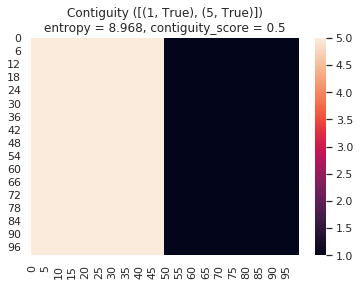

0 - {0, 1, 2} 1 [   0. 2244. 2244.]
2 + {0, 1}
5 + {0, 1}
0 - {0, 1, 2} 1 [   0. 2244. 2244.]
2 + {0, 1}
5 + {0, 1}


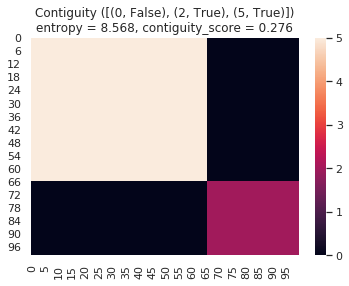

0 - {0, 1, 2} 1 [  0. 475. 475.]
2 + {0, 1}
5 + {0, 1}
0 - {0, 1, 2} 1 [  0. 475. 475.]
2 + {0, 1}
5 + {0, 1}


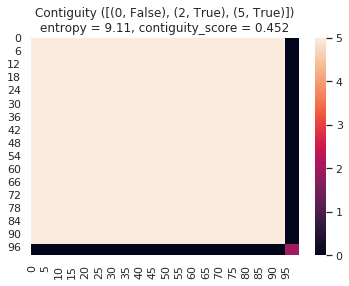

50.0 + {1}
50.0 + {1}


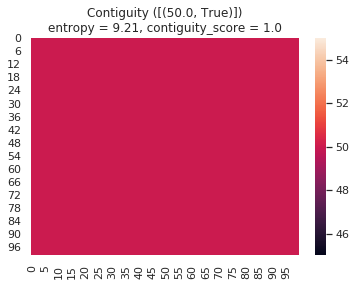

0.0 - {0, 1, 2} 1 [   0. 4500. 4500.]
5.0 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10} 1 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
0.0 - {0, 1, 2} 1 [   0. 4500. 4500.]
5.0 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10} 1 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


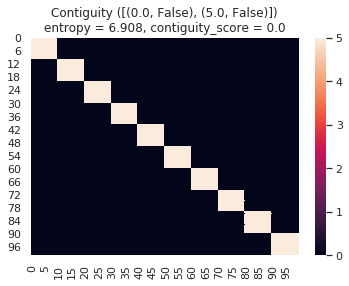

In [13]:
n, k = 100, 0.5
img = np.block([
    [np.ones((int(n*k),int(n*k)))*5, np.ones((int(n*k),int(n*(1-k))))*1],
    [np.ones((int(n*(1-k)),int(n*k)))*5, np.ones((int(n*(1-k)), int(n*(1-k))))*1]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

n, k = 100, 0.66
img = np.block([
    [np.ones((int(n*k),int(n*k)))*5, np.zeros((int(n*k),int(n*(1-k))))],
    [np.zeros((int(n*(1-k)),int(n*k))), np.ones((int(n*(1-k)), int(n*(1-k))))*2]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

n, k = 100, 0.95
img = np.block([
    [np.ones((int(n*k),int(n*k)))*5, np.zeros((int(n*k),int(n*(1-k))))],
    [np.zeros((int(n*(1-k)),int(n*k))), np.ones((int(n*(1-k)), int(n*(1-k))))*2]
]).astype(int)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

n = 100
img = np.ones((n,n))*50
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

n, repeats = 10, 10
block = np.ones((n,n))*5
img = np.kron(np.eye(repeats, dtype=int), block)
sns.heatmap(img)
plt.title("Contiguity ({})\nentropy = {}, contiguity_score = {}"
            .format([(label, is_contiguous(img, label)) for label in list(set(img.flatten()))],
                    scipy.stats.entropy(img.flatten()).round(3),
                    avg_contiguity_score(img)
                )
        )
plt.show()

I am running out of time so I am abandoning the experiment which compares performance over contiguity thresholds as I cannot satisfactorily assign a contiguity score to a given sample. The only experiments I will run are effcts on FMI of varying PPS, MMRA and AOI :(